In [1]:
import pandas as pd
import numpy as np
import statistics as stat
import os
import re
import random

import matplotlib.pyplot as plt
import seaborn as sns

import shap
from shap import TreeExplainer, summary_plot, dependence_plot

import imblearn 
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler

import sklearn
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score, cross_validate, RepeatedStratifiedKFold, RandomizedSearchCV, KFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit


#### Preprocessing Functions

In [2]:
def clean(df):
    deck = [re.sub('[0-9]*','',str(i)) for i in df['Cabin']]
    deck = [None if i=='nan' else i for i in deck]
    room = [re.sub('[a-zA-Z]*','',str(i)) for i in df['Cabin']]
    room = [int(i.split()[0]) if i!='' else None for i in room]

    df['deck'] = deck
    df['room'] = room

    df['female'] = [1 if i=='female' else 0 for i in df['Sex']]
    df = df.drop('Sex', axis=1)

    df = df.join(pd.get_dummies(df['Embarked']))
    df.drop('Embarked', axis=1)

    floors = {'A': 1,
     'B': 2,
     'C': 3,
     'D': 4,
     'E': 5,
     'F': 6,
     'G': 7,
     None: None,
     'T': None
    }

    df['deck'] = [i.split()[0] if i!=None else None for i in df.deck]
    df['deck'] = [floors[i] for i in df['deck']]

    df.loc[(df.Pclass==1)&(df.deck.isnull()),'deck'] = np.nanmedian(df[df['Pclass']==1]['deck'])
    df.loc[(df.Pclass==2)&(df.deck.isnull()),'deck'] = np.nanmedian(df[df['Pclass']==2]['deck'])
    df.loc[(df.Pclass==3)&(df.deck.isnull()),'deck'] = np.nanmedian(df[df['Pclass']==3]['deck'])
    df.loc[df.room.isnull(),'room'] = np.nanmedian(df.room)
    df.loc[df.Age.isnull(),'Age'] = np.nanmedian(df['Age'])
    
    df['fem_age'] = df['female']*df['Age']

    df.loc[df.Name.str.contains('Master'),'Master'] = 1
    df['Master'] = df['Master'].fillna(0)

    return df

def splitData(df):
    X = df[['Age','SibSp','Parch','deck','room','female','C','Q','S','Master','fem_age']]
    y = df['Survived']
    return  X, y


#### Clean and Balance Data

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train = clean(train)
test = clean(test)

X, y = splitData(train)

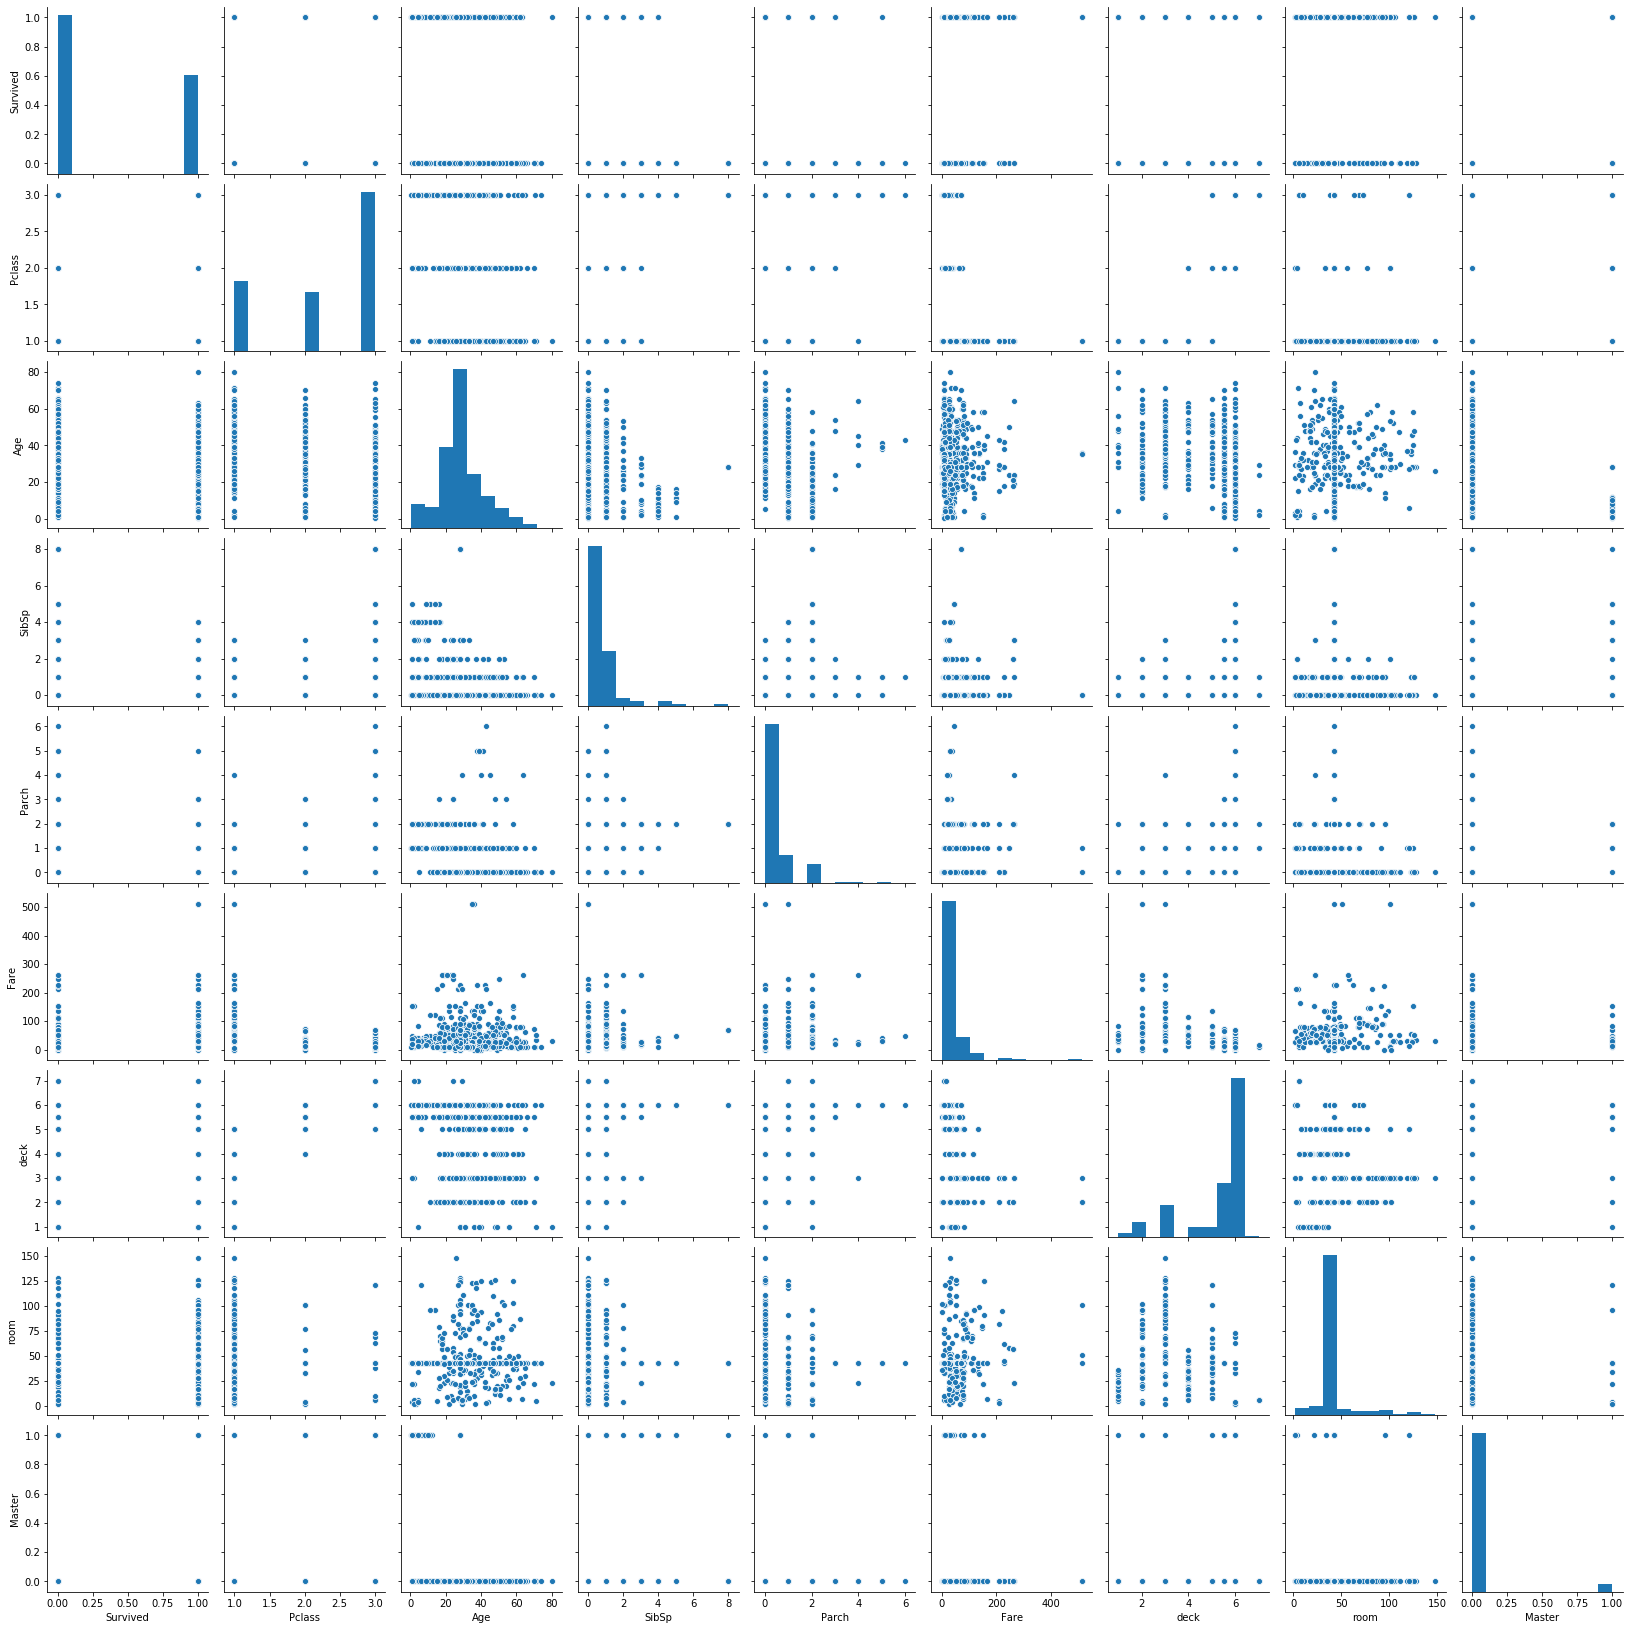

In [4]:
sns.pairplot(train[['Survived', 'Pclass', 'Age', 'SibSp',
                    'Parch', 'Fare', 'deck', 'room', 'Master']])

In [6]:
ros = RandomOverSampler()

X, y = ros.fit_resample(np.array(X), y)
X = pd.DataFrame(X)
X.columns = ['Age','SibSp','Parch','deck','room','female','C','Q','S','Master','fem_age']

print(stat.mean(train[train.C==1]['Survived']))
print(stat.mean(train[train.Q==1]['Survived']))
print(stat.mean(train[train.S==1]['Survived']))

0.5535714285714286
0.38961038961038963
0.33695652173913043


#### Logistic Regression

In [7]:
kf = KFold(n_splits=5)

lr = []
for k in np.linspace(0.05, 1, 20):
    score = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        clf = LogisticRegression(multi_class='ovr', 
                                 max_iter=1000).fit(X_train, y_train)
        y_pred = clf.predict_proba(X_test)
        y_pred = [1*(i[1]>k) for i in y_pred]

        s = np.mean([1 if i==j else 0 for (i,j) in zip(y_pred,y_test)])
        score.append(s)
    lr.append(np.mean(score))

print(max(lr))

0.7996139476961395


#### Support Vector Machine

In [8]:
svm = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    clf = make_pipeline(StandardScaler(), SVC(gamma='auto')).fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    svm.append(np.mean([1 if i==j else 0 for (i,j) in zip(y_pred,y_test)]))
print(np.mean(svm))


0.8069115815691159


#### Gradient Boosting

In [9]:
# define the model
model = GradientBoostingClassifier()

# define parameter space
distributions = dict(learning_rate = list(np.linspace(0.05,0.3,6)), 
                     n_estimators = list(range(1,11)), 
                     min_samples_split = list(range(2,8)))

# define cross validation
cv = KFold(shuffle = True, n_splits = 5)

# instantiate
clf = RandomizedSearchCV(model, distributions, cv=cv)


In [10]:
# define the model
search1_xgb = xgb.XGBClassifier(objective = 'binary:logistic',
                                eval_metric = 'error')

# define parameter space
param_dist = {'eta': list(np.linspace(0.05,0.3,6)), 
              'gamma': list(np.linspace(0,0.5,6))
             }

# define cross validation
cv = KFold(shuffle = True, n_splits = 5)

# instantiate
clf_xgb = RandomizedSearchCV(search1_xgb, param_dist, cv = cv)


In [11]:
# define the model
search1_lgb = lgb.LGBMClassifier(objective = 'binary',
                                eval_metric = 'error')

# define parameter space
param_dist = {'eta': list(np.linspace(0.05,0.3,6)), 
              'gamma': list(np.linspace(0,0.5,6))
             }

# define cross validation
cv = KFold(shuffle = True, n_splits = 5)

# instantiate
clf_lgb = RandomizedSearchCV(search1_lgb, param_dist, cv = cv)


In [13]:
search1 = clf.fit(X, y)
print('Gradient Boost: '+str(np.mean([1 if i==j else 0 for (i,j) in zip(y,search1.predict(X))])))

# fit XGBoost
search1_xgb = clf_xgb.fit(X, y)
print('XGBoost: '+str(np.mean([1 if i==j else 0 for (i,j) in zip(y,search1_xgb.predict(X))])))

# fit Light GBM
search1_lgb = clf_lgb.fit(X, y)
print('LGBM: '+str(np.mean([1 if i==j else 0 for (i,j) in zip(y,search1_lgb.predict(X))])))

Gradient Boost: 0.8123861566484517
XGBoost: 0.8588342440801457
LGBM: 0.9198542805100182


In [16]:
search1_lgb.best_estimator_

LGBMClassifier(eta=0.3, eval_metric='error', gamma=0.1, objective='binary')

#### Ensemble with LGBM

In [19]:
def random_split(X, y):
    idx = random.choices(list(range(X.shape[0])), k=X.shape[0])
    x_temp = X.loc[idx]
    y_temp = y.loc[idx]
    return x_temp, y_temp

In [20]:
X_1, y_1 = random_split(X, y)
search_lgb1 = lgb.LGBMClassifier(objective = 'binary',
                                 eval_metric = 'error',
                                 eta=0.3, 
                                 gamma=0.1)
search_lgb1.fit(X_1, y_1)

X_2, y_2 = random_split(X, y)
search_lgb2 = lgb.LGBMClassifier(objective = 'binary',
                                 eval_metric = 'error',
                                 eta=0.3, 
                                 gamma=0.1)
search_lgb2.fit(X_2, y_2)

X_3, y_3 = random_split(X, y)
search_lgb3 = lgb.LGBMClassifier(objective = 'binary',
                                 eval_metric = 'error',
                                 eta=0.3, 
                                 gamma=0.1)
search_lgb3.fit(X_3, y_3)

X_4, y_4 = random_split(X, y)
search_lgb4 = lgb.LGBMClassifier(objective = 'binary',
                                 eval_metric = 'error',
                                 eta=0.3, 
                                 gamma=0.1)
search_lgb4.fit(X_4, y_4)

X_5, y_5 = random_split(X, y)
search_lgb5 = lgb.LGBMClassifier(objective = 'binary',
                                 eval_metric = 'error',
                                 eta=0.3, 
                                 gamma=0.1)
search_lgb5.fit(X_5, y_5)

LGBMClassifier(eta=0.3, eval_metric='error', gamma=0.1, objective='binary')

In [21]:
lgbm_pred = pd.DataFrame(np.array([search_lgb1.predict(X),
             search_lgb2.predict(X),
             search_lgb3.predict(X),
             search_lgb4.predict(X),
             search_lgb5.predict(X)]))

preds = [np.median(lgbm_pred[i]) for i in lgbm_pred.columns]
np.mean([1 if i==j else 0 for (i,j) in zip(y,preds)])


0.907103825136612

#### Bagging

In [22]:
n_estimators = list(range(10,210,10))
cv = StratifiedShuffleSplit(n_splits=10, test_size=.30, random_state=15)

parameters = {'n_estimators':n_estimators}
grid = GridSearchCV(BaggingClassifier(base_estimator= None, ## If None, then the base estimator is a decision tree.
                                      bootstrap_features=False),
                                 param_grid=parameters,
                                 cv=cv,
                                 n_jobs = -1)
grid.fit(X,y)

np.mean([1 if i==j else 0 for (i,j) in zip(y,grid.predict(X))])

0.9444444444444444

#### Feature Importances

In [23]:
def plotImp(X, y, model):    
    # SHAP values
    explainer = TreeExplainer(model,
                             feature_perturbation = "tree_path_dependent")
    shapval = explainer.shap_values(X, y)
    summary_plot(shapval, X, X.columns)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


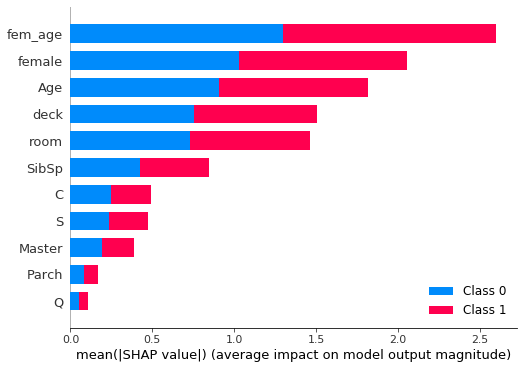

In [24]:
y_lgb1 = search_lgb1.predict(X)
plotImp(X, y_lgb1, search_lgb1)